In [197]:
import scipy.io
import numpy as np
import os

def read_save():
    path = "mci_dem_dataset/CONTROL/"
    arr = []
    for folder in os.listdir(path):
        if "normal" in folder:
            arr = []
            for file in os.listdir(path+folder):
                mat = scipy.io.loadmat(path+folder+"/"+file)["export"]
                if mat.shape[-1] == 19:
                    arr.extend(list(mat))
            if len(arr) > 0:
                arr = np.vstack(arr)
            else:
                arr = np.array(arr)
        else:
            mat = scipy.io.loadmat(path+folder)['segmenty']
        np.save("mci_ad_dataset_npy/"+str(folder[:-4]), arr) 
    path = "mci_dem_dataset/AD/"
    
    arr = []
    for folder in os.listdir(path):
        arr = []
        for file in os.listdir(path+folder):
            mat = scipy.io.loadmat(path+folder+"/"+file)["export"]
            if mat.shape[-1] == 19:
                arr.extend(list(mat))
        if len(arr) > 0:
            arr = np.vstack(arr)
        else:
            arr = np.array(arr)
        np.save("mci_ad_dataset_npy/"+str(folder), arr)
    path = "mci_dem_dataset/MCI/"
    
    arr = []
    for folder in os.listdir(path):
        arr = []
        for file in os.listdir(path+folder):
            mat = scipy.io.loadmat(path+folder+"/"+file)["export"]
            if mat.shape[-1] == 19:
                arr.extend(list(mat))
        if len(arr) > 0:
            arr = np.vstack(arr)
        else:
            arr = np.array(arr)
        np.save("mci_ad_dataset_npy/"+str(folder), arr)
        
read_save()

In [219]:
import glob, os
files = []
for file in glob.glob("mci_ad_dataset_npy/*.npy"):
    files.append(file)
print(len(files))

from sklearn.model_selection import train_test_split

TEST_DATA_SIZE = 0.5
TRAIN_DATA_SIZE = 0.5

train_files, test_files = train_test_split(files, test_size=TEST_DATA_SIZE, random_state=2025)

130


In [348]:
train_files

['mci_ad_dataset_npy/AD15.npy',
 'mci_ad_dataset_npy/7959fir.npy',
 'mci_ad_dataset_npy/6965fir.npy',
 'mci_ad_dataset_npy/AD42.npy',
 'mci_ad_dataset_npy/4401fir.npy',
 'mci_ad_dataset_npy/AD1.npy',
 'mci_ad_dataset_npy/AD21.npy',
 'mci_ad_dataset_npy/13601fir.npy',
 'mci_ad_dataset_npy/AD40.npy',
 'mci_ad_dataset_npy/AD18.npy',
 'mci_ad_dataset_npy/28021fir.npy',
 'mci_ad_dataset_npy/AD7.npy',
 'mci_ad_dataset_npy/AD47.npy',
 'mci_ad_dataset_npy/MCI4.npy',
 'mci_ad_dataset_npy/AD11.npy',
 'mci_ad_dataset_npy/AD13.npy',
 'mci_ad_dataset_npy/23010fir.npy',
 'mci_ad_dataset_npy/29845fir.npy',
 'mci_ad_dataset_npy/21565fir.npy',
 'mci_ad_dataset_npy/10057fir.npy',
 'mci_ad_dataset_npy/16875fir.npy',
 'mci_ad_dataset_npy/nor.npy',
 'mci_ad_dataset_npy/12099fir.npy',
 'mci_ad_dataset_npy/AD3.npy',
 'mci_ad_dataset_npy/MCI6.npy',
 'mci_ad_dataset_npy/AD50.npy',
 'mci_ad_dataset_npy/MCI7.npy',
 'mci_ad_dataset_npy/14672fir.npy',
 'mci_ad_dataset_npy/17264fir.npy',
 'mci_ad_dataset_npy/5103fi

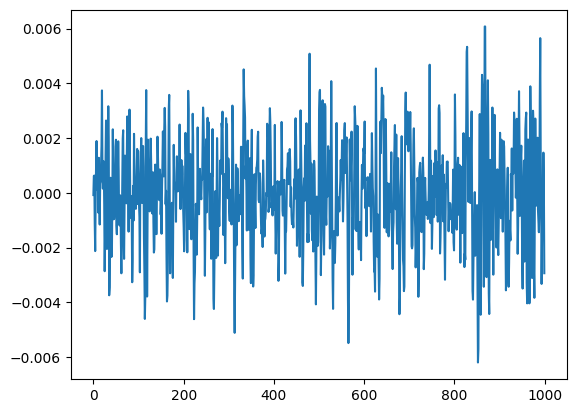

In [352]:
raw = np.load(train_files[1])
import matplotlib.pyplot as plt
plt.plot(raw[:1000, 10])
plt.show()

In [291]:
import mne
from tqdm import tqdm
from statsmodels.tsa.stattools import grangercausalitytests
import random
import numpy as np
from scipy.signal import savgol_filter, detrend
from scipy import signal

import pywt

import numpy as np
import scipy.signal as sig

from braindecode.preprocessing import exponential_moving_standardize

from sklearn.decomposition import FastICA


from numpy.lib.stride_tricks import sliding_window_view

def multichannel_sliding_window(X, size, step):
    shape = (X.shape[0] - X.shape[0] + 1, (X.shape[1] - size + 1) // step, X.shape[0], size)
    strides = (X.strides[0], X.strides[1] * step, X.strides[0], X.strides[1])
    return np.lib.stride_tricks.as_strided(X, shape, strides)[0]


def get_label(file):
    if "AD" in file:
        return [1]
    elif "MCI" in file:
        return [2]
    else:
        return [0]

def read_npy_file(file, use_windows=True, num_windows=100):
    data_raw = np.load(file)
    raws = []
    data_raw = data_raw.T
    data_raw = multichannel_sliding_window(data_raw, 100, 90)
    for i in range(0, 20, 5):
        if data_raw.shape[0] > (i+num_windows):
            raws.append(data_raw[i:(i+num_windows)])
    if not use_windows:
        try:
            raws = [raws[int(len(raws)/2)]]
        except:
            return
    return raws

from scipy import fftpack

def build_data(raw_data, use_windows=True, num_windows=100):
    
    all_data_features = []
    data_labels = []
    data_graphs = []
    
    for file in tqdm(raw_data):
        edf_data = read_npy_file(file, use_windows=use_windows, num_windows=num_windows)
        if not edf_data:
            continue
        for edf_data1 in edf_data:
            all_data_features.append(edf_data1)
            label = get_label(file)
            data_labels.append(np.array(label))
            
    all_data_features = np.array(all_data_features)
    data_labels = np.array(data_labels)
             
    return all_data_features, data_labels

In [292]:
import copy

from sklearn.preprocessing import OneHotEncoder
#from train import trainer
import torch
#from tgcn import TGCN
from torch.utils.data import TensorDataset,DataLoader
from scipy.stats import pearsonr

from numpy.lib.stride_tricks import sliding_window_view
from scipy import signal
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm
import itertools
from scipy.sparse import csgraph
from sklearn.feature_selection import mutual_info_regression
import spkit as sp

def multichannel_sliding_window(X, size, step):
    shape = (X.shape[0] - X.shape[0] + 1, (X.shape[1] - size + 1) // step, X.shape[0], size)
    strides = (X.strides[0], X.strides[1] * step, X.strides[0], X.strides[1])
    return np.lib.stride_tricks.as_strided(X, shape, strides)[0]


def hilphase(x1,x2):
    sig1_hill=sig.hilbert(x1)
    sig2_hill=sig.hilbert(x2)
    pdt=(np.inner(sig1_hill,np.conj(sig2_hill))/(np.sqrt(np.inner(sig1_hill,
               np.conj(sig1_hill))*np.inner(sig2_hill,np.conj(sig2_hill)))))
    phase = np.angle(pdt)
    return phase
    
def gc(x1, x2):
    X = np.vstack([x1, x2]).T
    gc = grangercausalitytests(X, [2], addconst=True, verbose=False)[2][0]['ssr_ftest'][1]
    return gc
    
    
# Coherence - δ
def coherence(eegData,fs):
    coh_res = []
    for ii, jj in itertools.combinations(range(eegData.shape[0]), 2):
        coh_res.append(CoherenceDelta(eegData, ii, jj, fs=fs))
    coh_res = np.array(coh_res)
    return coh_res

# Mutual information
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score

# https://github.com/ufvceiec/EEGRAPH/blob/develop-refactor/eegraph/strategy.py
def pli(data_intervals, i, j):
    sig1_phase = signal.hilbert([data_intervals[i]])
    sig2_phase = signal.hilbert([data_intervals[j]])
    phase_diff = sig1_phase[0] - sig2_phase[0]
    phase_diff = phase_diff.astype(float)
    phase_diff = (phase_diff  + np.pi) % (2 * np.pi) - np.pi
    pli = abs(np.mean(np.sign(phase_diff)))
    return pli
    

# Cross correlation 
# https://github.com/ufvceiec/EEGRAPH/blob/develop-refactor/eegraph/strategy.py
def calculate_cc(data_intervals, i, j):
    x = data_intervals[i]
    y = data_intervals[j]
    
    Rxy = signal.correlate(x,y, 'full')
    Rxx = signal.correlate(x,x, 'full')
    Ryy = signal.correlate(y,y, 'full')
    
    lags = np.arange(-len(data_intervals[i]) + 1, len(data_intervals[i]))
    lag_0 = int((np.where(lags==0))[0])

    Rxx_0 = Rxx[lag_0]
    Ryy_0 = Ryy[lag_0]
    
    Rxy_norm = (1/(np.sqrt(Rxx_0*Ryy_0)))* Rxy
    #We use the mean from lag 0 to a 10% displacement. 
    disp = round((len(data_intervals[i])) * 0.10)
    cc_coef = Rxy_norm[lag_0: lag_0 + disp].mean()
    return cc_coef
     
def cal_mi(x1, x2):
    x1 = x1.reshape(x1.shape[0], 1)
    mi = mutual_info_regression(x1, x2)
    return mi

# Mutual information
def calculate2Chan_MI(eegData,ii,jj,bin_min=-200, bin_max=200, binWidth=2):
    H = np.zeros(eegData.shape[2])
    bins = np.arange(bin_min+1, bin_max, binWidth)
    for epoch in range(eegData.shape[2]):
        c_xy = np.histogram2d(eegData[ii,:,epoch],eegData[jj,:,epoch],bins)[0]
        H[epoch] = mutual_info_score(None, None, contingency=c_xy)
    return H


import spkit as sp

def gen_graphs(eegs, num_nodes=19, cal_conn="cc"):
    #eegs(snapshots, bands, timpoints)
    c = []
    for i in range(num_nodes):
        c1 = []
        for j in range(num_nodes):
            if cal_conn == "pearson":
                conn = pearsonr(eegs[i], eegs[j])[0]
            elif cal_conn == "cc":
                conn = calculate_cc(eegs, i, j)
            elif cal_conn == "plv": 
                conn = hilphase(eegs[i], eegs[j])
            elif cal_conn == "pli":
                conn = pli(eegs, i, j)
            elif cal_conn == "gc": 
                conn = gc(eegs[i], eegs[j])
            elif cal_conn == "mi": 
                conn = sp.mutual_info(eegs[i], eegs[j])
            elif cal_conn == "con-entropy": 
                conn = sp.entropy_cond(eegs[i],eegs[j])
            elif cal_conn == "cross-entropy": 
                conn = sp.entropy_cross(eegs[i],eegs[j])
            elif cal_conn == "kld-entropy": 
                conn = sp.entropy_kld(eegs[i],eegs[j])
            elif cal_conn == "joint-entropy": 
                conn = sp.entropy_joint(eegs[i],eegs[j])
            c1.append(conn)
        c.append(c1)
    return c


def gen_features(X, y, device, cal_conn, window_size=100, overlap=0, augment=False, stft=False):
    X_new = []     

    #for x in X:
    #    x_ = multichannel_sliding_window(x, window_size, overlap)
    #    X_new.append(x_)
        
    X_new = np.moveaxis(np.array(X), 1, -1)
    graphs = []
    dynamic_range = X_new.shape[-1]
    threshold = 0.3
    
    print("calculating connectivity")
    for x in tqdm(X_new):
        temp = []
        for i in range(dynamic_range):
            temp_g = gen_graphs(x[:, :, i], cal_conn=cal_conn)
            temp_g = np.array(temp_g).squeeze()
            #temp_g = (temp_g - temp_g.min())/(temp_g.max() - temp_g.min())
            #temp_g[temp_g<threshold] = 0
            temp_g, d = csgraph.laplacian(temp_g, return_diag=True, normed=True)
            temp.append(temp_g)
        graphs.append(temp)
        
    
    # calculate STFT
    X_new = np.moveaxis(X_new, -1, 1)
    X = []
    for x in X_new:
        f, t, Zxx = signal.stft(x, 100, nperseg=100, noverlap=10, boundary=None, padded=None)
        X.append(np.abs(Zxx))
        
    X_new = np.array(X).squeeze()
    X_new = np.moveaxis(np.array(X_new), 1, -1)    
    print(X_new.shape)
    graphs = np.array(graphs)
    
    graphs = np.moveaxis(graphs.squeeze(), 1, -1)
        
    return X_new, graphs, y

import copy
def standardize_data(train_X, test_X):
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    for i in range(train_X.shape[1]):
        min_ = np.min(train_X[:, i, :])
        max_ = np.max(train_X[:, i, :])
        train_X_std[:, i, :] = (train_X[:, i, :] - min_)/(max_ - min_)
        test_X_std[:, i, :] = (test_X[:, i, :] - min_)/(max_ - min_)
    return train_X_std, test_X_std

In [293]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
import torch.nn as nn
from torch_scatter import scatter_add
from torch_geometric.utils import add_self_loops


class TGCN(torch.nn.Module):
    r"""An implementation of the Temporal Graph Convolutional Gated Recurrent Cell.
    For details see this paper: `"T-GCN: A Temporal Graph ConvolutionalNetwork for
    Traffic Prediction." <https://arxiv.org/abs/1811.05320>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        improved (bool): Stronger self loops. Default is False.
        cached (bool): Caching the message weights. Default is False.
        add_self_loops (bool): Adding self-loops for smoothing. Default is True.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
    ):
        super(TGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops

        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_z = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_z = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_reset_gate_parameters_and_layers(self):

        self.conv_r = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_r = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_h = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_h = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_weight, H):
        Z = torch.cat([self.conv_z(X, edge_index, edge_weight), H], axis=1)
        Z = self.linear_z(Z)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_weight, H):
        R = torch.cat([self.conv_r(X, edge_index, edge_weight), H], axis=1)
        R = self.linear_r(R)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_weight, H, R):
        H_tilde = torch.cat([self.conv_h(X, edge_index, edge_weight), H * R], axis=1)
        H_tilde = self.linear_h(H_tilde)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** *(PyTorch Float Tensor)* - Node features.
            * **edge_index** *(PyTorch Long Tensor)* - Graph edge indices.
            * **edge_weight** *(PyTorch Long Tensor, optional)* - Edge weight vector.
            * **H** *(PyTorch Float Tensor, optional)* - Hidden state matrix for all nodes.

        Return types:
            * **H** *(PyTorch Float Tensor)* - Hidden state matrix for all nodes.
        """
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_weight, H)
        R = self._calculate_reset_gate(X, edge_index, edge_weight, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_weight, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H
    
    
    
class A3TGCN(torch.nn.Module):
    r"""An implementation of the Attention Temporal Graph Convolutional Cell.
    For details see this paper: `"A3T-GCN: Attention Temporal Graph Convolutional
    Network for Traffic Forecasting." <https://arxiv.org/abs/2006.11583>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        periods (int): Number of time periods.
        improved (bool): Stronger self loops (default :obj:`False`).
        cached (bool): Caching the message weights (default :obj:`False`).
        add_self_loops (bool): Adding self-loops for smoothing (default :obj:`True`).
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        periods: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True
    ):
        super(A3TGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.periods = periods
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self._setup_layers()

    def _setup_layers(self):
        self._base_tgcn = TGCN(
            in_channels=3,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )
        self.Encoder =  Encoder(timepoints=100, num_nodes=19)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.attention = torch.nn.Parameter(torch.empty(self.periods, device=device))
        torch.nn.init.uniform_(self.attention)
        

    def forward(
        self,
        X: torch.FloatTensor,
        A: torch.FloatTensor,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** (PyTorch Float Tensor): Node features for T time periods.
            * **edge_index** (PyTorch Long Tensor): Graph edge indices.
            * **edge_weight** (PyTorch Long Tensor, optional)*: Edge weight vector.
            * **H** (PyTorch Float Tensor, optional): Hidden state matrix for all nodes.

        Return types:
            * **H** (PyTorch Float Tensor): Hidden state matrix for all nodes.
        """
        
        Xenc = self.Encoder(X)
        H_accum = 0
        probs = torch.nn.functional.softmax(self.attention, dim=0)
        for period in range(self.periods):
            Xt = Xenc[:, :, :, period]
            batch_size = Xt.shape[0]
            Xt = Xt.reshape(Xt.shape[0]*Xt.shape[1], Xt.shape[-1])
            At = A[:, :, :, period]
            At = torch.block_diag(*At)
            idx = (At > 0).nonzero().t().contiguous().long().to(X.device)
            row, col = idx
            w = At[row, col].float().to(X.device)
            
            #idx, w = get_laplacian(idx, w)
            
            temp_emb = self._base_tgcn(Xt, idx, w, H)
            temp_emb = temp_emb.reshape(batch_size, 19, 32)
            
            H_accum = H_accum + probs[period] * temp_emb #([32, 207, 32]
            
        return H_accum
    
    
class Encoder(nn.Module):
    def __init__(self, timepoints, num_nodes):
        super().__init__()
        self.conv1 = nn.Conv2d(num_nodes, 32, kernel_size=(3, 1), stride=(2, 1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1))
        self.pooling = torch.nn.AdaptiveAvgPool2d((num_nodes, 3))
        self.BN1 = nn.BatchNorm2d(64)
        self.BN2 = nn.BatchNorm2d(num_nodes)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.maxpool2(x)
        x = self.BN1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.pooling(x)
        x = x.permute(0, 2, 3, 1)
        #x = self.BN2(x)
        return x
    
    
class EEGModel(nn.Module):
    def __init__(self, num_nodes, node_features, num_classes, num_windows, device):
        super(EEGModel, self).__init__()
        self.a3tgnn = A3TGCN(in_channels=node_features, out_channels=32, periods=num_windows) # node_features=2, periods=12
        self.num_nodes = num_nodes
        self.BN = nn.BatchNorm1d(self.num_nodes)
        self.num_windows = num_windows
        self.fc2 = nn.Linear(self.num_nodes*32, num_classes)
        self.softmax = nn.LogSoftmax(-1)
        
    def forward(self, X, A):
        HS = self.a3tgnn(X, A)
        HS = nn.functional.relu(HS)
        HS = self.BN(HS)
        HS = HS.reshape(HS.shape[0], self.num_nodes*32)
        out = self.fc2(HS)    
        return out

In [334]:
from IPython.display import clear_output
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import OneHotEncoder
import copy

def standardize_data(train_X, test_X):
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    for i in range(train_X.shape[1]):
        min_ = np.min(train_X[:, i, :, :])
        max_ = np.max(train_X[:, i, :, :])
        train_X_std[:, i, :, :] = (train_X[:, i, :, :] - min_)/(max_ - min_)
        test_X_std[:, i, :, :] = (test_X[:, i, :, :] - min_)/(max_ - min_)
    return train_X_std, test_X_std


def standardize_data(train_X, test_X):
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    for i in range(train_X.shape[1]):
        for j in range(train_X.shape[2]):
            min_ = np.min(train_X[:, i, j, :])
            max_ = np.max(train_X[:, i, j, :])
            train_X_std[:, i, j, :] = (train_X[:, i, j, :] - min_)/(max_ - min_)
            test_X_std[:, i, j, :] = (test_X[:, i, j, :] - min_)/(max_ - min_)
    return train_X_std, test_X_std

def train_test(train_files, test_files, num_windows, cal_conn, use_test_windows=False):
    print("read_data")
    train_X, train_y = build_data(train_files, use_windows=True, num_windows=num_windows)
    test_X, test_y = build_data(test_files, use_windows=use_test_windows, num_windows=num_windows)
    clear_output()
    #print("standardize_data")
    print(train_X.shape, test_X.shape)
    DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    train_X, train_graphs, train_y = gen_features(train_X, train_y, DEVICE, cal_conn=cal_conn, 
                                                  window_size=100, overlap=90, augment=False)
    test_X, test_graphs, test_y = gen_features(test_X, test_y, DEVICE, cal_conn=cal_conn, 
                                               window_size=100, overlap=90, augment=False)
    
    #train_X, test_X = standardize_data(train_X, test_X)
    
    clear_output()
    encoder = OneHotEncoder()
    train_y = encoder.fit_transform(train_y).toarray()
    test_y = encoder.transform(test_y).toarray()
    train_X = torch.Tensor(train_X)
    test_X = torch.Tensor(test_X)
    train_y= torch.Tensor(train_y)
    test_y = torch.Tensor(test_y)
    test_graphs= torch.Tensor(test_graphs)
    train_graphs = torch.Tensor(train_graphs)
    
    batch_size = 64
    data = TensorDataset(train_X, train_graphs, train_y)
    train_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=True)
    data = TensorDataset(test_X, test_graphs, test_y)
    test_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=False)
    
    return train_iter, test_iter

In [274]:
import glob, os
from sklearn.model_selection import KFold
    
def train_kfold(files_kfold):
    all_train_losses = []
    all_val_losses = []
    
    kf = KFold(n_splits=3, shuffle=True, random_state=2024)
    for k, (train_files_, val_files_) in enumerate(kf.split(files_kfold)):
        print("Kfold", k)
        train_files_ = [files_kfold[i] for i in train_files_]
        val_files_ = [files_kfold[i] for i in val_files_]
        train_iter, val_iter = train_test(train_files=train_files_, 
                                          test_files=val_files_,
                                          num_windows=200,
                                          cal_conn="corr",
                                          use_test_windows=True)
        
        DEVICE = torch.device('cpu')
        model = EEGModel(num_nodes=19, node_features=300, num_classes=2, num_windows=332, device=DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    
        print("Training model")
        model.train()
        for epoch in range(10):
            losses = 0
            for idx, (X, A, y) in enumerate(tqdm(train_iter)):
                optimizer.zero_grad()
                out = model(X, A)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                losses += loss.item()*X.shape[0]
            losses = losses/len(train_iter.dataset)
            print("Epoch ", epoch+1, ":")
            print("Kfold train loss", losses)
            all_train_losses.append(losses)
            losses = 0
            
            for idx, (X, A, y) in enumerate(val_iter):
                optimizer.zero_grad()
                out = model(X, A)
                loss = criterion(out, y)
                losses += loss.item()*X.shape[0]
            losses = losses/len(val_iter.dataset)
            print("Kfold val loss", losses)
            all_val_losses.append(losses)
    clear_output()
    return all_train_losses, all_val_losses

In [279]:
import glob, os
from sklearn.model_selection import train_test_split
    
def train_val(files):
    all_train_losses = []
    all_val_losses = []

    train_subset_files, val_files = train_test_split(files, test_size=0.1, random_state=2024)
    train_iter, val_iter = train_test(train_files=train_subset_files, 
                                      test_files=val_files,
                                      overlap_size=200,
                                      cal_conn="corr",
                                      use_test_windows=True)
    
    DEVICE = torch.device('cpu')
    model = EEGModel(num_nodes=19, node_features=300, num_classes=2, num_windows=332, device=DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=2e-4)

    print("Training model")
    model.train()
    for epoch in range(50):
        losses = 0
        for idx, (X, A, y) in enumerate(tqdm(train_iter)):
            optimizer.zero_grad()
            out = model(X, A)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            losses += loss.item()*X.shape[0]
        losses = losses/len(train_iter.dataset)
        print("Epoch ", epoch+1, ":")
        print("train loss", losses)
        all_train_losses.append(losses)
        losses = 0
        
        for idx, (X, A, y) in enumerate(val_iter):
            optimizer.zero_grad()
            out = model(X, A)
            loss = criterion(out, y)
            losses += loss.item()*X.shape[0]
        losses = losses/len(val_iter.dataset)
        print("val loss", losses)
        all_val_losses.append(losses)
    clear_output()
    return all_train_losses, all_val_losses

In [312]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score

def print_acc(model, data_iter):
    outs= []
    ys = []
    
    model.eval()
    with torch.no_grad():
        for X, A, y in data_iter:
            out = model(X, A)
            outs.extend(out.cpu().detach().numpy())
            ys.extend(y.cpu().detach().numpy())
    
    outs = np.array(outs)
    ys = np.array(ys)
    outs = np.argmax(outs, -1)
    ys = np.argmax(ys, -1)

    print("accuracy:", accuracy_score(outs, ys),
          "f1 score:", f1_score(outs, ys,  average="micro"),
          "precision:",precision_score(outs, ys,  average="micro"),
          "recall:", recall_score(outs, ys,  average="micro"),
          "confusion matrix:", confusion_matrix(outs, ys))

    metrics = [accuracy_score(outs, ys), f1_score(outs, ys,  average="micro"), 
               precision_score(outs, ys,  average="micro"), recall_score(outs, ys,  average="micro"),
               confusion_matrix(outs, ys)]
    
    return metrics


def train_model(model, num_epochs):

    model.train()
    for epoch in range(num_epochs): 
        losses = 0
        for idx, (X, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            out = model(X, A)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
    return model

In [344]:
conn_types = ["cc", "pearson", "plv", "pli", "mi", "con-entropy", "cross-entropy", "kld-entropy", "joint-entropy"]
num_epochs = 38
results = {}
for conn in conn_types:
    print(conn)
    train_iter, test_iter = train_test(train_files=train_files, 
                                       test_files=test_files, 
                                       num_windows=60,
                                       cal_conn=conn)    
    
    torch.manual_seed(2024)
    DEVICE = torch.device('cpu')
    final_model = EEGModel(num_nodes=19, node_features=51, num_classes=3, num_windows=60, device=DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(final_model.parameters(),lr=1e-4)
    model = train_model(final_model, num_epochs)
    results[conn] = print_acc(model, test_iter)
clear_output()

In [345]:
results

{'cc': [0.9384615384615385,
  0.9384615384615385,
  0.9384615384615385,
  0.9384615384615385,
  array([[34,  2,  0],
         [ 0, 27,  2],
         [ 0,  0,  0]])],
 'pearson': [0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  array([[34,  1,  0],
         [ 0, 28,  2],
         [ 0,  0,  0]])],
 'plv': [0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  array([[34,  1,  0],
         [ 0, 28,  2],
         [ 0,  0,  0]])],
 'pli': [0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  array([[34,  1,  0],
         [ 0, 28,  2],
         [ 0,  0,  0]])],
 'mi': [0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  array([[34,  1,  0],
         [ 0, 28,  2],
         [ 0,  0,  0]])],
 'kld-entropy': [0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  0.9538461538461539,
  array([[34,  1,  0],
         [ 0, 28,  2],
         [ 0, 